# System genetics assignment 2

### Setup

In [1]:
import os
import platform
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def get_genotype_phenotype_df(all_snps_df, chosen_phenotype_df, is_include_heterozygos_genotypes=False):
	'''
	Description
	-----------
	Make a dataframe with snps as their original letter, the numaric represantation of them and the phenotype value.
	The function will always drop "U" - unknown genotypes and if is_include_geterozygos_genotypes=True it will incluse hetezygos (H) individuals as well.
	This function does not change the state of the provided dataframes.

	Parameters
	----------
	all_snps_df : pandas dataframe
		The dataframe containing the individuals and thier genotype as a single letter.
		D and B are homozygos parental genotypes, H is geterozygos and U is unknown.
	chosen_phenotype_df : pandas dataframe
		The dataframe containing the individuals and thier phenotype measurement as a float from the chosen phenotype row (only a single row is expected).
	is_include_heterozygos_genotypes : bool
		if set to True, then heterozygos individuals will be included in the returned matrix

	Returns
	-------
	genotype_phenotype_df : pandas dataframe
		Fields:
			individual : str
				The individual BXD id (ex BXD1)
			snp_locus : str,
				The snp locus indentifier (ex rs6269442)
			snp_chr : int,
				the snp chromosome (1, 2...)
			genotype_letter : str,
				B and D denote parental homozyges individuals and H denotes a heterozygos individual
			genotype_num : int,
				The genotype_letter converted to a number, B=0, H=1, D=2
			phenotype_value : float
				The value of the phenotype to associate as a float
	'''
	chosen_phenotype_df_data = chosen_phenotype_df.copy()
	# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
	chosen_phenotype_df_data = chosen_phenotype_df_data.iloc[:, 7:]
	# As a first step, remove columns from the phenotypes df that have NaN in them.
	# Since we are expecting a single row then this is OK and won't destroy data for other associations.
	chosen_phenotype_df_data = chosen_phenotype_df_data.dropna(axis=1, how='any')

	# Now remove all genotypes for which we do not have a phenotypic measurement
	snps_df = all_snps_df.copy()
	# Split to data and metadata for ease of work
	snps_df_metadata = snps_df.iloc[:, :4]
	snps_df_data = snps_df.iloc[:, 4:]
	# For some reasson there are 'b' values in the file convert them to 'B'
	snps_df_data = snps_df_data.replace('b', 'B')

	# Get the columns to keep
	common_columns = snps_df_data.columns.intersection(chosen_phenotype_df_data.columns)
	snps_df_data = snps_df_data.loc[:, common_columns]
	# Put all the data back into the original dataframe
	snps_df = pd.concat([snps_df_metadata, snps_df_data], axis=1)

	# As the last step of data cleaning set the letters to drop.
	# U is always dropped, and if we aren't keeping heterozygos individuals then remove H as well.
	letters_to_drop = ['U']
	if not is_include_heterozygos_genotypes:
		letters_to_drop.append('H')

	snps_df = snps_df.replace(letters_to_drop, pd.NA)

	# Prepare all columns to be saved into a flattened df
	individuals_column = np.tile(snps_df_data.columns, snps_df_data.shape[0])
	locus_column = np.tile(snps_df['Locus'].values.flatten(), snps_df_data.shape[1])
	chr_column = np.tile(snps_df['Chr_Build37'].values.flatten(), snps_df_data.shape[1])
	chr_pos_column = np.tile(snps_df['Build37_position'].values.flatten(), snps_df_data.shape[1])
	binary_rep = [ 0 if value == 'B' else (1 if value == 'H' else 2) for value in snps_df_data.values.flatten()]
	phenotypes_column = np.tile(chosen_phenotype_df_data, snps_df_data.shape[0])[0]
	
	
	# Create the final dataframe
	genotype_phenotype_df = pd.DataFrame({
		'individual' : individuals_column,
		'locus' : locus_column,
		'chr' : chr_column,
		'position' : chr_pos_column,
		'genotype_num' : binary_rep,
		'phenotype_value' : phenotypes_column
	})

	# Since the letter are across many fields it's easier to fill the column this way as opposed to what was done above
	genotype_phenotype_df['genotype_letter'] = genotype_phenotype_df['genotype_num'].apply(lambda x: 'B' if x == 0 else ('H' if x == 1 else 'D'))

	# Move 'phenotype_value' column to the end
	columns = [col for col in genotype_phenotype_df.columns if col != 'phenotype_value'] + ['phenotype_value']
	genotype_phenotype_df = genotype_phenotype_df[columns]


	return genotype_phenotype_df

In [3]:
def statsmodels_linear_regression(X, y, is_heterozygos_included=False):
	'''
	Description
	-----------
	Perform a linear regression using the statsmodels implematation for the data points provided in X and y

	Parameters
	----------
	X : np array
		The X values for the observations to regress on
	y : np array
		The y values for the observations to regress to
	is_heterozygos_included : bool
		If the plot should have H in the middle, no data manipulation is done based on this parameter
		
	Returns
	-------
	(m, b, p_value) of the optimal regression line found at the the of the specified number of epochs
	'''
	# Use statmodels to perform the regression analysis
	genotype_numbers_for_sm = sm.add_constant(X)
	reg_model = sm.OLS(y, genotype_numbers_for_sm)
	results = reg_model.fit()

	# Plot the data and the regression line
	fig, ax = plt.subplots(figsize=(8, 8))
	ax.scatter(X, y)
	if is_heterozygos_included:
		ax.set_xlabel('Locus base (B=0, H=1, D=2)')
	else:
		ax.set_xlabel('Locus base (B=0, D=2)')
	ax.set_ylabel('Climbing scores after 16 mg/kg i.p. \nmethamphetamine injection [quadrant crossings/min]')

	ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]:.2f},\n p value = {results.pvalues[0]:.2f}')

	plt.legend()
	plt.show()

	return (results.rsquared_adj, results.params[1], results.pvalues[0])

In [4]:
def statmodels_anova(df, formula):
	'''
	Description
	-----------
	Perform an anova test using the statsmodels implematation for the data points provided df. The each sublist will be treated as a group.
	For two groups only.

	Parameters
	----------
	df : pandas dataframe 
		With the columns as described in the formula provided
	formula : str
		ANOVA formula with the structure defined in the statmodels docs 

	Returns
	-------
	p_val : float
		The p value of the test for the difference in means of the two groups.
	'''
	model = smf.ols(formula, data=df).fit()
	anova_table = sm.stats.anova_lm(model, typ=2)

	# Calculate p-value scores
	p_value = anova_table['PR(>F)'][0]

	return p_value, anova_table

### Read data from files and save it under a single df using get_genotype_phenotype_df

In [5]:
# Based on the platform choose the file locations
if platform.system() == 'Windows':
	# Rotem's file paths
	genotype_file_path = os.path.normpath('')
	phenotypes_file_path = os.path.normpath('')
else:
	# Carmi's file paths
	genotype_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/genotypes.xls')
	phenotypes_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/phenotypes.xls')
	

genotypes_df = pd.read_excel(genotype_file_path)
chosen_phenotype_df = pd.read_excel(phenotypes_file_path)

In the genotype table, B and D denote parental homozyges individuals and H denotes a heterozygos individual. U are unknows and will therefore be dropped when using their data

Import the Climbing scores after 16 mg/kg i.p. methamphetamine injection [quadrant crossings/min] phenotype from the phenotype table

In [6]:
chosen_phenotype_row = chosen_phenotype_df.loc[chosen_phenotype_df.ID_FOR_CHECK == 172]
# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
chosen_phenotype_row_data_homozygos = chosen_phenotype_row.iloc[:, 7:]

display(chosen_phenotype_row)

,ID_FOR_CHECK,Phenotype,Authors,Year,Pubmed Id,C57BL/6J,DBA/2J,BXD1,BXD2,BXD5,...,BXD94,BXD95,BXD96,BXD97,BXD98,BXD99,BXD100,BXD101,BXD102,BXD103
172,172,Climbing scores after 16 mg/kg i.p. methamphet...,"Grisel JE, Belknap JK, O'Toole LA, Helms ML, W...",1997,8987796.0,2.3,0.6,0.1,-0.8,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
genotype_phenotype_df = get_genotype_phenotype_df(genotypes_df, chosen_phenotype_row, is_include_heterozygos_genotypes=True)
display(genotype_phenotype_df)

,individual,locus,chr,position,genotype_num,genotype_letter,phenotype_value
0,BXD1,rs6269442,1,3482276,0,B,0.1
1,BXD2,rs6365999,1,4811063,0,B,-0.8
2,BXD5,rs6376963,1,5008090,2,D,1.5
3,BXD6,rs3677817,1,5176059,2,D,-0.8
4,BXD8,rs8236463,1,5579194,2,D,0.3
...,...,...,...,...,...,...,...
91099,BXD28,CEL-X_154259201,20,160727280,0,B,1.0
91100,BXD29,rs3657281,20,160951100,0,B,-1.4
91101,BXD30,rs13484106,20,162637898,2,D,2.6
91102,BXD31,gnfX.146.867,20,163124563,0,B,-0.8


## Question 1

### Models assumptions

1) Linear regression:
- Knowing in advance if the regression runs only on homozhous individuals or both heterozygous one as well
- Exisntance of linear correlation between the snps and phenotype value
- An error term Ɛ, For all i in our dataset, E(Ɛ_i) = 0 and therefore E(y_i | x_i) = ß_0 + ß_1 * X_1
- The error term are independent For all i in our dataset, V(Ɛ_i) = σ^2 therefore, for each i and j in our dataset where i != j cov(Ɛ_i, Ɛ_j) = 0


2) Anova model assumptions:
- Independence of Observations
- Normality of residuals. The residuals should be approximately normally distributed
- The variance among the groups should be approximately equal
- The effect of each factor is approximately additive

### Find a locus with hetroziygosity

In [8]:
chosen_snp_with_h = genotype_phenotype_df.loc[genotype_phenotype_df.genotype_letter == 'H'].iloc[0].locus
# Grab the data based on the locus id
chosen_snp_with_h_data = genotype_phenotype_df.loc[genotype_phenotype_df['locus'] == chosen_snp_with_h]

display(chosen_snp_with_h_data)
print(chosen_snp_with_h_data.shape)

,individual,locus,chr,position,genotype_num,genotype_letter,phenotype_value
1525,BXD21,rs3671932,6,134808128,2,D,0.1
5321,BXD25,rs3671932,6,134808128,2,D,0.6
9117,BXD30,rs3671932,6,134808128,2,D,2.6
12913,BXD2,rs3671932,6,134808128,0,B,-0.8
16709,BXD11,rs3671932,6,134808128,2,D,-0.1
20505,BXD15,rs3671932,6,134808128,2,D,-0.7
24301,BXD21,rs3671932,6,134808128,2,D,0.1
28097,BXD25,rs3671932,6,134808128,0,B,0.6
31893,BXD30,rs3671932,6,134808128,2,D,2.6
35689,BXD2,rs3671932,6,134808128,0,B,-0.8


(24, 7)


### (a) linear regression model in which heterozygous markers are ignored

In [9]:
chosen_snp_no_h = chosen_snp_with_h_data[chosen_snp_with_h_data['genotype_letter'] != 'H']
display(chosen_snp_no_h)
display(chosen_snp_no_h.shape)

,individual,locus,chr,position,genotype_num,genotype_letter,phenotype_value
1525,BXD21,rs3671932,6,134808128,2,D,0.1
5321,BXD25,rs3671932,6,134808128,2,D,0.6
9117,BXD30,rs3671932,6,134808128,2,D,2.6
12913,BXD2,rs3671932,6,134808128,0,B,-0.8
16709,BXD11,rs3671932,6,134808128,2,D,-0.1
20505,BXD15,rs3671932,6,134808128,2,D,-0.7
24301,BXD21,rs3671932,6,134808128,2,D,0.1
28097,BXD25,rs3671932,6,134808128,0,B,0.6
31893,BXD30,rs3671932,6,134808128,2,D,2.6
35689,BXD2,rs3671932,6,134808128,0,B,-0.8


(23, 7)

And we can see that the H locus was dropped as needed

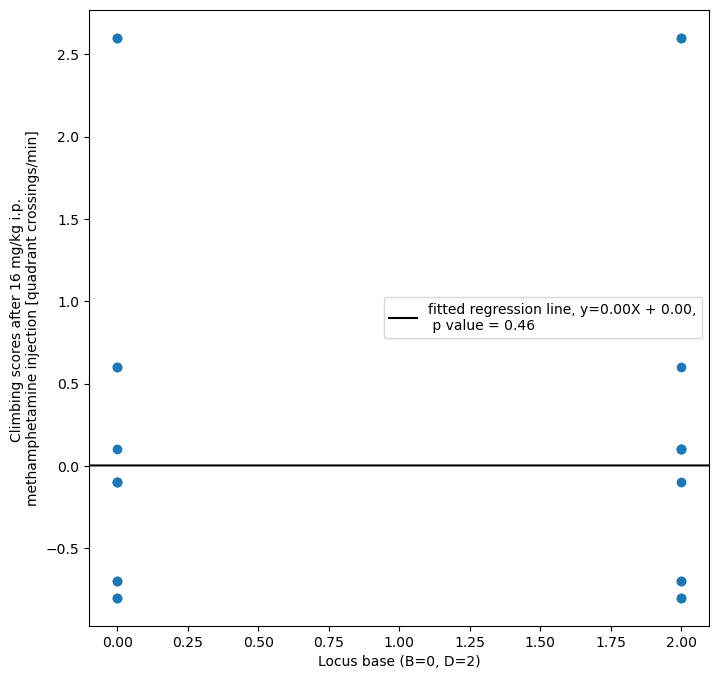

(-0.04761193485777593, 0.0030303030303030355, 0.4558715119298036)

In [10]:
statsmodels_linear_regression(np.array(chosen_snp_no_h['genotype_num']), np.array(chosen_snp_no_h['phenotype_value']))

### (b) linear regression model in which heterozygous markers are considered

/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/2130462216.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]:.2f},\n p value = {results.pvalues[0]:.2f}')
/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/2130462216.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axline((0, results.params[1]), slope=results.rsquared, color='black' ,label=f'fitted regression line, y={results.rsquared:.2f}X + {results.params[1]:.2f},\n p value =

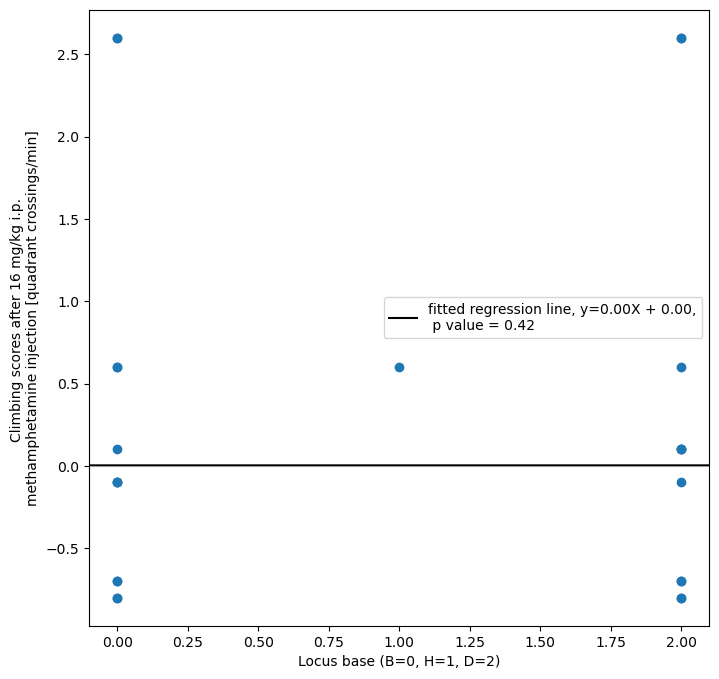

/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/2130462216.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (results.rsquared_adj, results.params[1], results.pvalues[0])


(-0.04544439471267436, 0.0036297640653358137, 0.4193782950933116)

In [11]:
# Check the linear regression result
statsmodels_linear_regression(chosen_snp_with_h_data['genotype_num'], chosen_snp_with_h_data['phenotype_value'], is_heterozygos_included=True)

### (c) ANOVA model in which heterozygous markers are ignored

In [12]:
formula = 'phenotype_value ~ C(genotype_num)'
p_val, anova_table = statmodels_anova(chosen_snp_no_h, formula)
display(anova_table)
print(f'THe ANOVA p-value is {p_val:.2f} > 0.05 and therefore ANOVA agrees with the previous two subsections. \nThe SNP is not signficantly correlated with any change in the phenotype mean value')

/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/160205476.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


,sum_sq,df,F,PR(>F)
C(genotype_num),0.000211,1.0,0.000143,0.990586
Residual,31.048485,21.0,NaN,NaN


THe ANOVA p-value is 0.99 > 0.05 and therefore ANOVA agrees with the previous two subsections. 
The SNP is not signficantly correlated with any change in the phenotype mean value


## Question 2

### (a) Anova on homozygous markers only (F-test) on the selected phenotype using each of the SNPs in the genotyping file

In [13]:
genotype_phenotype_df_no_h = get_genotype_phenotype_df(genotypes_df, chosen_phenotype_row, is_include_heterozygos_genotypes=False)

formula = 'phenotype_value ~ C(genotype_num)'
p_values_uncorrected = []

for index, row in genotypes_df.iterrows():
	chosen_snp_df = genotype_phenotype_df_no_h.loc[genotype_phenotype_df_no_h['locus'] == row['Locus']]
	chosen_snp_df_no_heterozygots = chosen_snp_df[chosen_snp_df['genotype_letter'] != 'H']
	p_value, _ = statmodels_anova(chosen_snp_df, formula)
	p_values_uncorrected.append((p_value,  row['Build37_position']))

/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/160205476.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/160205476.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/var/folders/74/_th8g7pd6bn069y4b54_fs480000gn/T/ipykernel_24603/160205476.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

### (b) Manhattan plot

In [14]:
# Convert to numpy array for ease of manipulations
p_values_uncorrected_np_arr = np.array(p_values_uncorrected)
positions = p_values_uncorrected_np_arr[:, 1]

Correct for multiple hypothesis testing, with both Bonferroni and Benjamini–Hochberg

In [15]:
p_val_bonferroni_corrected = p_values_uncorrected_np_arr[:, 0] * int(genotype_phenotype_df_no_h.shape[0] / 24)

p_val_bonferroni_corrected_log_transformed = np.log10(p_val_bonferroni_corrected) * -1
# Since p values that were close to 1 would tuen into a large positive number after -log we want to set the negetives to 0
p_val_bonferroni_corrected_log_transformed[p_val_bonferroni_corrected_log_transformed < 0] = 0

In [16]:
_, p_val_benjamini_hochberg_corrected = fdrcorrection(p_values_uncorrected_np_arr[:, 0])
# The benjamini_hochberg does not yield negative values
p_val_benjamini_hochberg_corrected_log_transformed = np.log10(p_val_benjamini_hochberg_corrected) * -1

In [17]:
def find_fdr_threshold(p_values, alpha=0.05):
	m = len(p_values)

	# Sort p-values and get their sorted index positions
	sorted_p_values = np.sort(p_values)

	# Calculate thresholds
	bh_thresholds = np.array([(i+1) / m * alpha for i in range(m)])

	# Find the largest p-value that is less than or equal to the corresponding BH threshold
	significant = sorted_p_values <= bh_thresholds
	max_significant_index = np.where(significant)[0].max()

	# The p-value threshold for significance
	p_value_threshold = sorted_p_values[max_significant_index]

	# Convert p-value threshold to -log10 scale
	log10_threshold = -np.log10(p_value_threshold)

	return log10_threshold

Create the file with genomic position, and -log10 of the following, raw p values, and the Bonferroni and Benjamini–Hochberg corrected p values each as a column

In [18]:
p_values_to_export = pd.DataFrame( { 'position' : positions,
                                     'original_p_values_minus_log10_transformed' : -np.log10(p_values_uncorrected_np_arr[:, 0]),
                                     'bonferroni_p_values_minus_log10_transformed' :  p_val_bonferroni_corrected_log_transformed,
                                     'benjamini_hochberg_p_values_minus_log10_transformed' :  p_val_benjamini_hochberg_corrected_log_transformed } )

p_values_to_export.to_csv('p_values_to_export.csv')

In [19]:
def manhattan_plot(positions, log_p_values, method='Bonferroni', p_vals_for_fdr_threshold = []):
    # Put the data arrays into a dataframe
	df = pd.DataFrame( { 'position' : positions, 'log_p_val' : log_p_values } )
	best_snp = df.loc[df['log_p_val'].idxmax()]
	print(" best-scored SNP:" + str(best_snp))

	# Creating the Manhattan plot
	plt.figure(figsize=(12, 6))
	plt.scatter(df['position'], df['log_p_val'])
	plt.xlabel('position')
	plt.ylabel('-log P-value')
	plt.title('Manhattan Plot')

	if method == 'Bonferroni':
		plt.axhline(y=-np.log10(0.05 / len(df)), color='r', linestyle='--', label='Bonferroni threshold')
	elif method == 'fdr':
		plt.axhline(y=find_fdr_threshold(p_vals_for_fdr_threshold), color='r', linestyle='--', label='Benjamini Hochberg threshold')

	plt.legend()
	plt.show()

 best-scored SNP:position     1.195033e+08
log_p_val    2.718187e+00
Name: 2260, dtype: float64


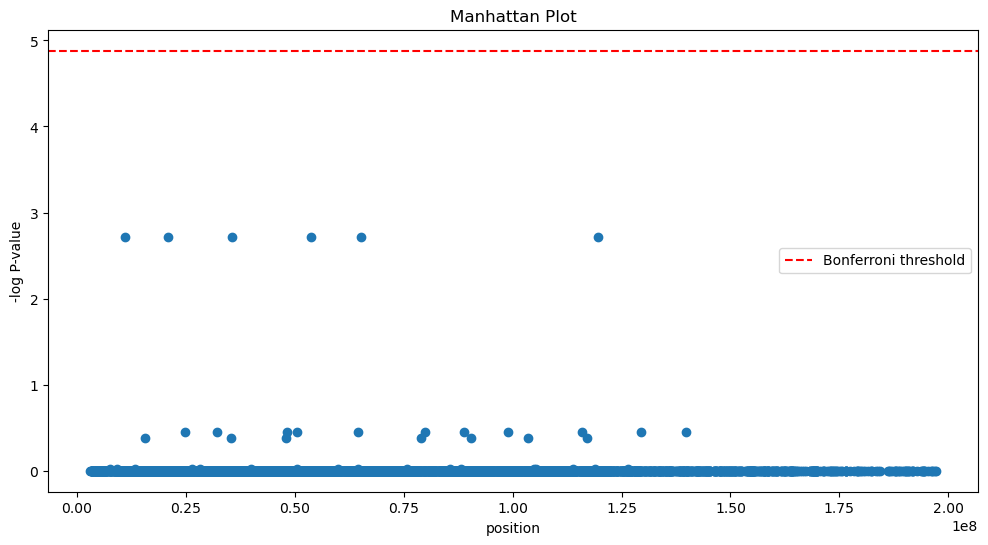

In [20]:
manhattan_plot(positions, p_val_bonferroni_corrected_log_transformed)

 best-scored SNP:position     1.195033e+08
log_p_val    3.496339e+00
Name: 2260, dtype: float64


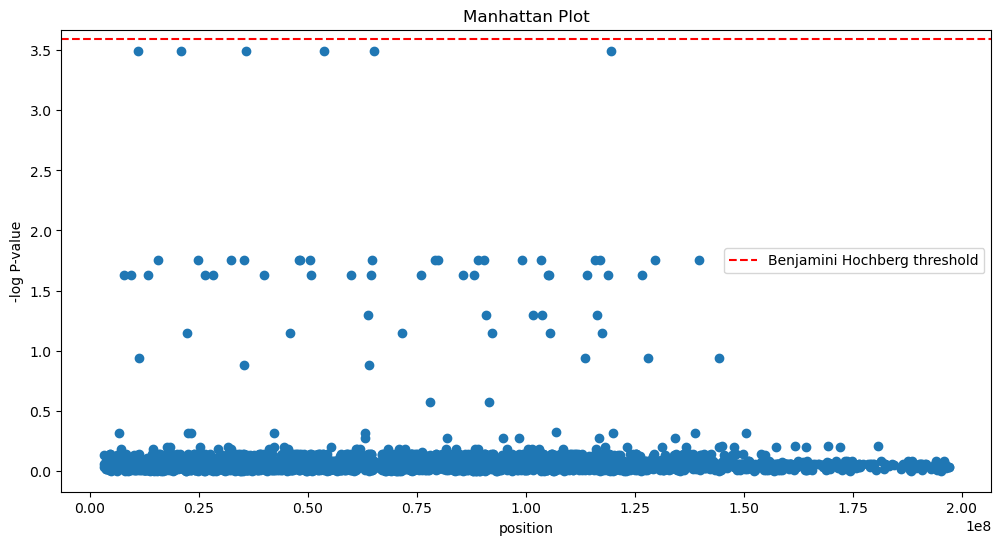

In [21]:
manhattan_plot(positions, p_val_benjamini_hochberg_corrected_log_transformed, method='fdr', p_vals_for_fdr_threshold = p_values_uncorrected_np_arr[:, 0])

### (c) 

Summary, Our results do not align with the papers results we found no hits while they found multiple significant QTLs for the climbing behaviour.

We couldn't find a mention of which fdr method that was used in the paper, therefore this could be the cause of difference between our analysis and the one published.

Paper link: https://www.jneurosci.org/content/17/2/745.long